In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import numpy as np
import pybedtools
import tqdm

running this notebook for other eCLIP data. Might want to include more RBPs in the paper. 

In [2]:
gtf_path = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley/refs/gencode.v43.annotation.gtf'

In [3]:
gtf_df = pd.read_csv(gtf_path, sep='\t', comment='#',header=None)
gtf_df = gtf_df[gtf_df[2]=='transcript']
gtf_df['transcript_id'] = gtf_df.apply(lambda x: x[8].split(';')[1].split('\"')[1], axis=1)
gtf_df['gene_id'] = gtf_df.apply(lambda x: x[8].split(';')[0].split('\"')[1].split('.')[0], axis=1)
gtf_df['gene_name'] = gtf_df.apply(lambda x: x[8].split(';')[3].split('\"')[1], axis=1)
gene_id_gene_name = dict(zip(gtf_df.gene_id, gtf_df.gene_name))
gene_name_gene_id = dict(zip(gtf_df.gene_name, gtf_df.gene_id))
transcript_id_gene_name = dict(zip(gtf_df.transcript_id, gtf_df.gene_name))
transcript_id_gene_id = dict(zip(gtf_df.transcript_id, gtf_df.gene_id))

In [4]:
kd_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/'

In [6]:
candidates = [ 'GRB2', 'NUDT21'
              , 'RNPS1', 'MBNL2', 'TRNAU1AP', 'RBM22', 'RBM10','CPSF6', 'ZC3HAV1', 'STAU2', 'EIF4B', 'LGALS3']


In [7]:
candidate_tables = [i for i in glob.glob(os.path.join(kd_dir, '*APA_table.txt')) if i.split('/')[-1].split('_')[1] in candidates]

In [8]:
candidate_tables

['/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/20241118_RBM22_APA_table.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/20241119_LGALS3_APA_table.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/20241118_MBNL2_APA_table.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/20241119_RBM10_APA_table.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/20241119_STAU2_APA_table.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/20241119_ZC3HAV1_APA_table.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq/20241119_TRNAU1AP_APA_table.txt',
 '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/d

In [9]:
def return_class(df):
    if df['log(treatment.p/treatment.d)'] > df['log(Ctrl.p/Ctrl.d)']:
        return 'proximal'
    elif df['log(treatment.p/treatment.d)'] < df['log(Ctrl.p/Ctrl.d)']:
        return 'distal'

In [10]:
rbp_tables_dict = {}
for rbp_table in candidate_tables:
    test = pd.read_csv(rbp_table, sep='\t')
    test['treatment.p + 1'] = test['treatment.p'] + 1
    test['treatment.d + 1'] = test['treatment.d'] + 1
    test['Ctrl.p + 1'] = test['Ctrl.p'] + 1
    test['Ctrl.d + 1'] = test['Ctrl.d'] + 1
    test['log(treatment.p/treatment.d)'] = test.apply(lambda x: np.log2(x['treatment.p + 1']/x['treatment.d + 1']), axis=1)
    test['log(Ctrl.p/Ctrl.d)'] = test.apply(lambda x: np.log2(x['Ctrl.p + 1']/x['Ctrl.d + 1']), axis=1)
    test['apa_class'] = test.apply(return_class, axis=1)
    test['apa_type'] = test.apply(lambda x: f"{x['TYPE.p']}_{x['TYPE.d']}", axis=1)
    rbp_tables_dict[rbp_table.split('/')[-1].split('_')[1]] = test
    

In [11]:
eclip_df_dict = {}
for g in candidates: 
    if g!='NUDT21':
        eclip_table = pd.read_csv(f'/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/eclip/skipper_runs/{g}/output/reproducible_enriched_windows/{g}.reproducible_enriched_windows.tsv.gz', sep='\t')
        eclip_table = eclip_table[(eclip_table['enrichment_l2or_mean'] >=3) & (eclip_table['p_min'] < 0.05)][['chr', 'start', 'end', 'gene_name', 'score', 'strand']]
        eclip_df_dict[g] = eclip_table
    else:
        eclip_table = pd.read_csv(f'/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/eclip/skipper_runs/CPSF5/output/reproducible_enriched_windows/CPSF5.reproducible_enriched_windows.tsv.gz', sep='\t')
        eclip_table = eclip_table[(eclip_table['enrichment_l2or_mean'] >=3) & (eclip_table['p_min'] < 0.05)][['chr', 'start', 'end', 'gene_name', 'score', 'strand']]
        eclip_df_dict[g] = eclip_table
    

In [13]:
eclip_table.head()

,chr,start,end,gene_name,score,strand
0,chr13,97276335,97276409,MBNL2,0,+
1,chr19,1998552,1998650,BTBD2,0,-
2,chr13,97357481,97357558,MBNL2,0,+
3,chr13,97343015,97343082,MBNL2,0,+
4,chr13,97357558,97357635,MBNL2,0,+


In [14]:
pct_overlap_list = []
for g in candidates:

    eclip_genes_set = set(eclip_df_dict[g]['gene_name'])
    passeq_genes_set = set(rbp_tables_dict[g]['SYMBOL'])

    pct_overlap = (len(passeq_genes_set.intersection(eclip_genes_set))/len(passeq_genes_set)) *100
    #print(g, len(passeq_genes_set.intersection(eclip_genes_set)))
    #print(g, len(passeq_genes_set))

    pct_overlap_list.append([g, pct_overlap, 100-pct_overlap])

In [15]:
pct_overlap_df = pd.DataFrame(pct_overlap_list, columns=['RBP', 'pct', '100-pct']).sort_values('pct', ascending=False).set_index('RBP')

In [16]:
pct_overlap_df

,pct,100-pct
RBP,,
RNPS1,96.000000,4.000000
EIF4B,87.500000,12.500000
CPSF6,85.474860,14.525140
STAU2,82.051282,17.948718
ZC3HAV1,71.033210,28.966790
NUDT21,70.298260,29.701740
GRB2,58.139535,41.860465
MBNL2,51.809524,48.190476
RBM10,48.000000,52.000000


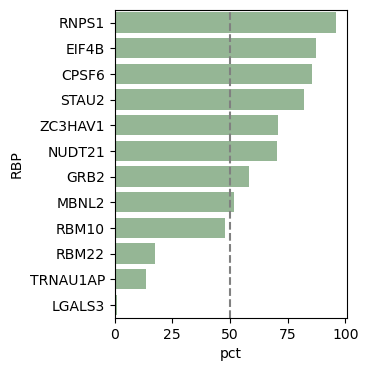

In [17]:
plt.rcParams['figure.figsize'] = [3, 4]

sns.barplot(data=pct_overlap_df, y='RBP', x='pct', color='darkseagreen', orient='h')
plt.xticks(rotation=0)
plt.axvline(x=50, color='grey', linestyle='--')
# plt.savefig('./figures/eclip_pas_pct_pas_overlap_barplot.png')
# plt.savefig('./figures/eclip_pas_pct_pas_overlap_barplot.jpg')
# plt.savefig('./figures/eclip_pas_pct_pas_overlap_barplot.svg')

In [18]:
bound_and_mod = {}
for g in candidates:
    bound_and_mod[g] = list(set(rbp_tables_dict[g]['SYMBOL']).intersection(set(eclip_df_dict[g]['gene_name'])))

In [19]:
common_genes ={}
for g in bound_and_mod:
    common_genes[g] = [gene_name_gene_id[i] for i in bound_and_mod[g] if i in gene_name_gene_id ]

In [25]:
bound_and_mod.keys()

dict_keys(['GRB2', 'NUDT21', 'RNPS1', 'MBNL2', 'TRNAU1AP', 'RBM22', 'RBM10', 'CPSF6', 'ZC3HAV1', 'STAU2', 'EIF4B', 'LGALS3'])

In [21]:
# Generate HOMER commands
homer_cmds= []
for g in candidates:
    if (os.path.exists(f'./eclip_overlap_homer/{g}/') ==False):
        homer_cmds.append(f'findMotifsGenome.pl {g}_eclip_bound_and_mod_re_windows.bed hg38 ./{g} -len 6,8 -rna')

print(';'.join(homer_cmds))

In [ ]:
gtf = pd.read_csv('gencode.v38.annotation.hek293t.gt1.tiled_partition.features.tsv', comment='#', sep='\t')[['chrom', 'start', 'end', 'feature_types', 'score', 'strand']]

In [ ]:
keep_regions = ['CDS:EXON_MRNA', 'INTRON', 'UTR5:EXON_MRNA', 'UTR3:EXON_MRNA']

In [ ]:
features_df = pd.DataFrame()
for g in tqdm.tqdm(candidates):
    if g!= 'NUDT21':
        a = pybedtools.BedTool(f'../../../eclip/{g}_eclip_enriched_windows.bed')
        
    elif g=='NUDT21':
        a = pybedtools.BedTool(f'../../../eclip/CPSF5_eclip_enriched_windows.bed')
    b = pybedtools.BedTool('gencode.v38.annotation.hek293t.gt1.tiled_partition.features.bed')
        
    
    
    # Find the intersection
    intersect = a.intersect(b,loj=True)
    
    # # Convert the result to a dataframe
    # intersect_df = pd.read_csv(intersect.fn, sep='\t', header=None)
    re_feature_overlap = pd.read_csv(intersect.fn, sep='\t', header=None).drop_duplicates(subset=[0,1,2,3])
    re_feature_overlap = re_feature_overlap[re_feature_overlap[3].isin(bound_and_mod[g])]
    re_feature_overlap = pd.DataFrame(re_feature_overlap[9].value_counts()).T[[i for i in pd.DataFrame(re_feature_overlap[9].value_counts()).T.columns if i in keep_regions] ]
    re_feature_overlap['candidate'] = g
    print(g, pd.read_csv(intersect.fn, sep='\t', header=None).drop_duplicates(subset=[0,1,2,3]).shape[0])
    features_df = pd.concat([features_df, re_feature_overlap])


In [34]:
features_df = features_df.set_index('candidate')

In [35]:
features_df

9,INTRON,UTR3:EXON_MRNA,UTR5:EXON_MRNA,CDS:EXON_MRNA
candidate,,,,
GRB2,7686.0,160.0,7.0,1.0
NUDT21,405.0,7464.0,7.0,123.0
RNPS1,13.0,22.0,14.0,149.0
MBNL2,178.0,468.0,118.0,859.0
TRNAU1AP,513.0,44.0,1.0,85.0
RBM22,28.0,NaN,NaN,NaN
RBM10,3.0,NaN,NaN,NaN
CPSF6,2347.0,338.0,122.0,2582.0
ZC3HAV1,81.0,758.0,78.0,750.0


In [36]:
features_df_copy = features_df.copy()
features_df_copy['total'] = features_df_copy.sum(axis=1)

In [37]:
for f in keep_regions:
    features_df_copy[f'pct_{f}'] = features_df_copy[f'{f}']/features_df_copy['total']

In [38]:
features_df_copy = features_df_copy.rename(columns={'pct_UTR5:EXON_MRNA' : "5\' UTR", 
                                 'pct_CDS:EXON_MRNA' : "CDS", 
                                 'pct_INTRON' : 'Intron',
                                 'pct_UTR3:EXON_MRNA' : "3\' UTR"
                                })

In [39]:
colorblind_palette = ["#0072B2", "#D55E00", "#CC79A7", "#F0E442"]

In [40]:
features_df_copy

9,INTRON,UTR3:EXON_MRNA,UTR5:EXON_MRNA,CDS:EXON_MRNA,total,CDS,Intron,5' UTR,3' UTR
candidate,,,,,,,,,
GRB2,7686.0,160.0,7.0,1.0,7854.0,0.000127,0.978610,0.000891,0.020372
NUDT21,405.0,7464.0,7.0,123.0,7999.0,0.015377,0.050631,0.000875,0.933117
RNPS1,13.0,22.0,14.0,149.0,198.0,0.752525,0.065657,0.070707,0.111111
MBNL2,178.0,468.0,118.0,859.0,1623.0,0.529267,0.109673,0.072705,0.288355
TRNAU1AP,513.0,44.0,1.0,85.0,643.0,0.132193,0.797823,0.001555,0.068429
RBM22,28.0,NaN,NaN,NaN,28.0,NaN,1.000000,NaN,NaN
RBM10,3.0,NaN,NaN,NaN,3.0,NaN,1.000000,NaN,NaN
CPSF6,2347.0,338.0,122.0,2582.0,5389.0,0.479124,0.435517,0.022639,0.062720
ZC3HAV1,81.0,758.0,78.0,750.0,1667.0,0.449910,0.048590,0.046791,0.454709


<Axes: ylabel='candidate'>

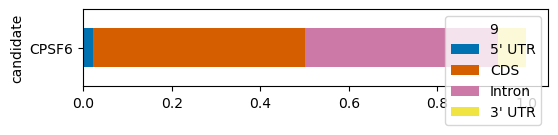

In [41]:
plt.rcParams['figure.figsize'] = [6, 1]
features_df_copy[features_df_copy.index.isin(['CPSF5', 'CPSF6'])][["5\' UTR", "CDS", "Intron", "3\' UTR"]].sort_values(by=["3\' UTR","Intron"]).plot.barh(stacked=True, color=colorblind_palette)
# plt.savefig('re_controls_eclip_features_overlap.png')
# plt.savefig('re_controls_eclip_features_overlap.svg')
# plt.savefig('re_controls_eclip_features_overlap.jpg')

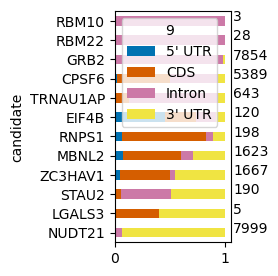

In [50]:
plt.rcParams['figure.figsize'] = [1.5, 3]
#features_df_copy[~features_df_copy.index.isin(['CPSF5', 'CPSF6', 'NUDT21'])][["5\' UTR", "CDS", "Intron", "3\' UTR"]].sort_values(by=["3\' UTR","Intron"]).plot.bar(stacked=True, color=colorblind_palette)
plot_all_features = features_df_copy[~features_df_copy.index.isin([])].sort_values(by=["3\' UTR","Intron"], ascending=[False, False])
plot_all_features[["5\' UTR", "CDS", "Intron", "3\' UTR"]].plot.barh(stacked=True, color=colorblind_palette)
for index, row in plot_all_features.reset_index().iterrows():
    plt.text(1.07, index, int(row['total']))
plt.savefig('./figures/re_eclip_features_overlap.png')
plt.savefig('./figures/re_eclip_features_overlap.svg')
plt.savefig('./figures/re_eclip_features_overlap.jpg')

In [48]:
plot_all_features[["5\' UTR", "CDS", "Intron", "3\' UTR"]]

9,5' UTR,CDS,Intron,3' UTR
candidate,,,,
NUDT21,0.000875,0.015377,0.050631,0.933117
LGALS3,NaN,0.400000,NaN,0.600000
STAU2,NaN,0.057895,0.452632,0.489474
ZC3HAV1,0.046791,0.449910,0.048590,0.454709
MBNL2,0.072705,0.529267,0.109673,0.288355
RNPS1,0.070707,0.752525,0.065657,0.111111
EIF4B,0.458333,0.275000,0.183333,0.083333
TRNAU1AP,0.001555,0.132193,0.797823,0.068429
CPSF6,0.022639,0.479124,0.435517,0.062720


In [42]:
features_df_copy

9,INTRON,UTR3:EXON_MRNA,UTR5:EXON_MRNA,CDS:EXON_MRNA,total,CDS,Intron,5' UTR,3' UTR
candidate,,,,,,,,,
GRB2,7686.0,160.0,7.0,1.0,7854.0,0.000127,0.978610,0.000891,0.020372
NUDT21,405.0,7464.0,7.0,123.0,7999.0,0.015377,0.050631,0.000875,0.933117
RNPS1,13.0,22.0,14.0,149.0,198.0,0.752525,0.065657,0.070707,0.111111
MBNL2,178.0,468.0,118.0,859.0,1623.0,0.529267,0.109673,0.072705,0.288355
TRNAU1AP,513.0,44.0,1.0,85.0,643.0,0.132193,0.797823,0.001555,0.068429
RBM22,28.0,NaN,NaN,NaN,28.0,NaN,1.000000,NaN,NaN
RBM10,3.0,NaN,NaN,NaN,3.0,NaN,1.000000,NaN,NaN
CPSF6,2347.0,338.0,122.0,2582.0,5389.0,0.479124,0.435517,0.022639,0.062720
ZC3HAV1,81.0,758.0,78.0,750.0,1667.0,0.449910,0.048590,0.046791,0.454709


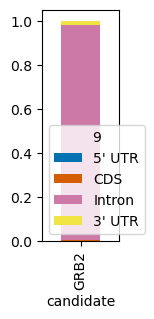

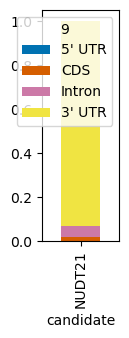

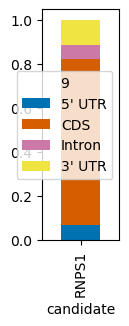

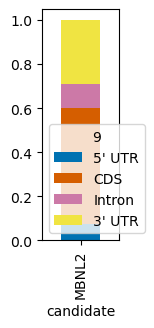

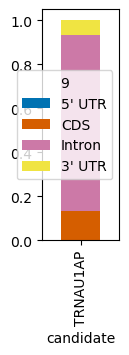

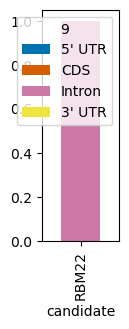

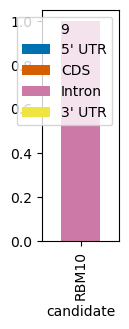

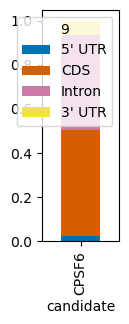

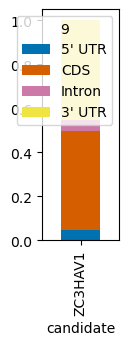

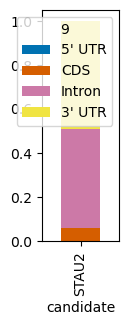

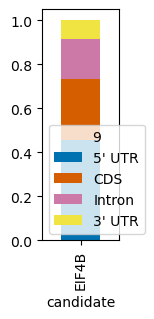

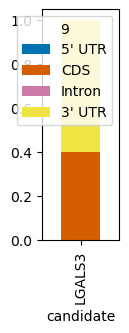

In [64]:
for c in list(features_df_copy.index):
    plt.rcParams['figure.figsize'] = [1, 3]
    features_df_copy[features_df_copy.index.isin([c])][["5\' UTR", "CDS", "Intron", "3\' UTR"]].sort_values(by=["3\' UTR","Intron"]).plot.bar(stacked=True, color=colorblind_palette)
    # plt.savefig(f'./figures/{c}_bound_mod_re_features.png')
    # plt.savefig(f'./figures/{c}_bound_mod_re_features.svg')
    # plt.savefig(f'./figures/{c}_bound_mod_re_features.jpg')

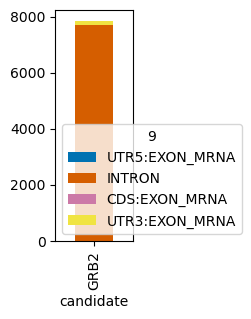

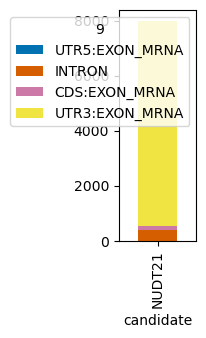

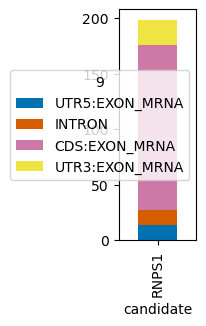

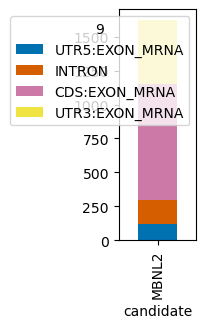

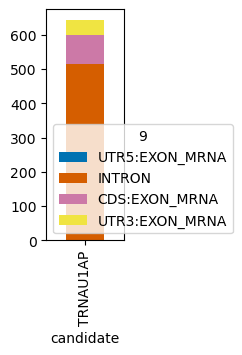

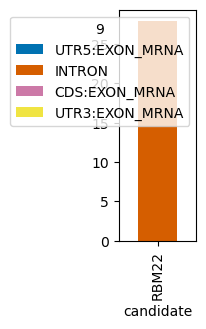

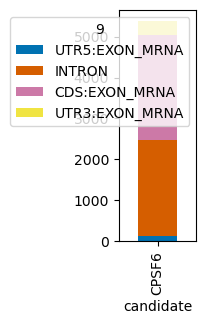

In [57]:
for c in list(features_df_copy.index):
    plt.rcParams['figure.figsize'] = [1, 3]
    features_df_copy[features_df_copy.index.isin([c])][["UTR5:EXON_MRNA","INTRON","CDS:EXON_MRNA","UTR3:EXON_MRNA"]].sort_values(by=["CDS:EXON_MRNA","INTRON"]).plot.bar(stacked=True, color=colorblind_palette)